In [ ]:
import warnings
warnings.filterwarnings("ignore")

# importing the required packages
import os
import gc
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [ ]:
# reading in the modeling data file - data_for_modeling_v1.csv
df = pd.read_csv('/content/drive/MyDrive/DISC_Files/data_for_modeling_v1.csv')

# shape of the dataframe
print(f'The shape is: {df.shape}')

# drop NaNs
df.dropna(inplace=True)

df.head()

The shape is: (15932, 13)


,Filename,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
0,111.0,1.0,0.963863,0.609352,0.975313,0.959778,0.632192,-0.470902,0.506764,0.939568,0.900406,0.940843,0.359740
1,111.0,0.0,0.398719,-0.665858,0.148063,-0.320505,-0.601653,0.699704,-0.780290,0.010630,-0.578635,-0.338233,-0.928304
2,111.0,0.0,0.667711,-0.599589,-0.186584,-0.334513,-0.753472,0.275028,-0.953558,-0.070705,-0.809290,-0.585002,-0.979120
3,111.0,0.0,0.063796,-0.693331,-0.823101,-0.699281,-0.881050,-0.167234,-0.791614,-0.354255,-0.808926,-0.849664,-0.982701
4,111.0,0.0,0.682714,-0.669648,0.270976,-0.172038,-0.714363,0.509748,-0.893044,0.088637,-0.509610,-0.372560,-0.943003


In [ ]:
# filtering the data for only the files from day 2, 3, 4
df['Filename'] = df['Filename'].astype(int)
df['Filename'] = df['Filename'].astype(str)
df = df[df['Filename'].str.startswith(('2', '3', '4'))]

# removing three files: 217, 328, 431 - which will be used in the evaluating the model performance for real case scenarios
df = df[~df['Filename'].isin(['217', '328', '431'])]
df = df.reset_index().drop(columns=['index'])

# shape of the dataframe
print(f'The shape is: {df.shape}')

df.head()

The shape is: (8812, 13)


,Filename,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
0,212,1.0,0.993877,0.707081,0.947555,0.966955,0.732989,0.508204,0.795057,0.978443,0.980676,0.936802,0.625439
1,212,0.0,-0.290215,-0.809753,-0.977933,-0.769555,-0.949636,-0.646668,-0.957724,-0.874027,-0.970369,-0.935073,-0.998177
2,212,0.0,-0.457561,-0.512547,-0.930690,-0.502719,-0.761839,-0.080047,-0.933530,-0.611755,-0.979494,-0.743474,-0.997258
3,212,0.0,0.456968,-0.718826,-0.841057,-0.659229,-0.904486,-0.144708,-0.890875,-0.486908,-0.885450,-0.869279,-0.989958
4,212,0.0,0.369176,-0.712746,-0.853916,-0.563484,-0.929465,-0.813405,-0.733183,-0.440282,-0.568248,-0.865125,-0.980265


In [ ]:
# X data for classification
X = df[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11']]
print(X.head())

   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.993877   0.707081   0.947555   0.966955   0.732989   0.508204   
1  -0.290215  -0.809753  -0.977933  -0.769555  -0.949636  -0.646668   
2  -0.457561  -0.512547  -0.930690  -0.502719  -0.761839  -0.080047   
3   0.456968  -0.718826  -0.841057  -0.659229  -0.904486  -0.144708   
4   0.369176  -0.712746  -0.853916  -0.563484  -0.929465  -0.813405   

   feature_7  feature_8  feature_9  feature_10  feature_11  
0   0.795057   0.978443   0.980676    0.936802    0.625439  
1  -0.957724  -0.874027  -0.970369   -0.935073   -0.998177  
2  -0.933530  -0.611755  -0.979494   -0.743474   -0.997258  
3  -0.890875  -0.486908  -0.885450   -0.869279   -0.989958  
4  -0.733183  -0.440282  -0.568248   -0.865125   -0.980265  


In [ ]:
# y data for classification
y = df['label']
print(y.head())

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: label, dtype: float64


In [ ]:
# splitting the X and y data into training and test data
# training data will be used for cross-validation purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Shape of training data is: {X_train.shape}')
print(f'Shape of test data is: {X_test.shape}')

Shape of training data is: (7049, 11)
Shape of test data is: (1763, 11)


**Random Forest Classifier**

In [ ]:
# define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300, 500, 700, 1000, 1200, 1500, 2000, 2200, 2500, 3000],  # number of trees in the forest
    'max_depth': [2, 5, 7, 10, 15, 20],  # maximum depth of the trees
}

In [ ]:
# create a random forest classifier
rf_model = RandomForestClassifier(random_state=42)

In [ ]:
# create the GridSearchCV object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=0)

In [ ]:
# fit the model to the training data
grid_search.fit(X_train, y_train)

# get the best parameters found by grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# fit random forest classifier with best hyperparameters again
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train, y_train)

# save the best model
joblib.dump(best_rf_model, '/content/drive/MyDrive/DISC_Files/ML_n3_model.pkl')

Best Hyperparameters: {'max_depth': 5, 'n_estimators': 700}


['/content/drive/MyDrive/DISC_Files/ML_n3_model.pkl']

In [ ]:
# getting predictions using the model
y_test_preds = best_rf_model.predict(X_test)

AUC: 0.92
Accuracy: 98.07
Sensitivity: 85.03
Specificity: 99.26
Precision (Purity): 91.24



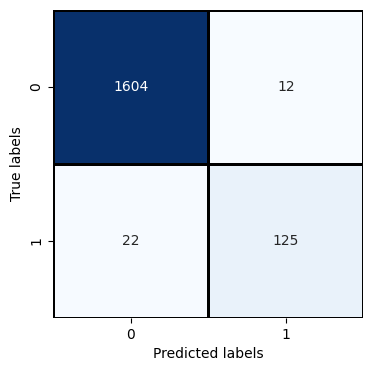

In [ ]:
# extracting predictions and labels
predictions = y_test_preds
labels = y_test

# confusion matrix
cm = confusion_matrix(labels, predictions)

# calculate TP, TN, FP, FN
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# calculate precision (purity)
precision = (TP / (TP + FP))*100

# calculate sensitivity
sensitivity = (TP / (TP + FN))*100

# calculate specificity
specificity = (TN / (TN + FP))*100

# calculate accuracy
accuracy = ((TP + TN) / (TP + TN + FP + FN))*100

# Calculate AUC
auc = roc_auc_score(labels, predictions)

# print everything
print(f"AUC: {auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision (Purity): {precision:.2f}\n")

# plot confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=1, linecolor='black')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

**Analyzing the model performance for real case scenarios**

In [ ]:
# changing directory and verifying
%cd /content/drive/MyDrive/DISC_Files/with_cell
!ls -v

/content/drive/MyDrive/DISC_Files/with_cell
111.csv  142.csv  223.csv  263.csv  333.csv  414.csv  438.csv  463.csv	529.csv  556.csv   3311.csv
112.csv  143.csv  224.csv  264.csv  334.csv  415.csv  439.csv  464.csv	531.csv  557.csv   4110.csv
113.csv  144.csv  225.csv  311.csv  335.csv  416.csv  441.csv  465.csv	532.csv  561.csv   4111.csv
114.csv  151.csv  226.csv  312.csv  336.csv  417.csv  442.csv  466.csv	533.csv  562.csv   4210.csv
115.csv  152.csv  227.csv  313.csv  337.csv  418.csv  443.csv  467.csv	534.csv  563.csv   4211.csv
116.csv  153.csv  231.csv  314.csv  338.csv  419.csv  444.csv  511.csv	535.csv  564.csv   4310.csv
117.csv  154.csv  232.csv  315.csv  339.csv  421.csv  445.csv  512.csv	536.csv  565.csv   4311.csv
121.csv  161.csv  233.csv  316.csv  341.csv  422.csv  446.csv  513.csv	537.csv  566.csv   4410.csv
122.csv  162.csv  234.csv  317.csv  342.csv  423.csv  447.csv  514.csv	538.csv  567.csv   4411.csv
123.csv  163.csv  235.csv  318.csv  343.csv  424.csv  448.csv  51

In [ ]:
# load the saved model
ML_n1_model = joblib.load('/content/drive/MyDrive/DISC_Files/ML_n3_model.pkl')

In [ ]:
# create the label_modified column
def modify_data(df):

    # make groups
    df['group'] = (df['label'] != df['label'].shift()).cumsum()

    # cummulative count for each group
    df['counter'] = df.groupby('group').cumcount() + 1

    # mark the rows with the cummulative count >= K and label = 1 as True
    df['label_modified'] = (df['label'] == 1) & (df['counter'] >= 18)

    # for each group - check if any of the row is marked as 1, if so, mark all the rows in the group as True, then convert the whole column to 1/0
    df['label_modified'] = df.groupby('group')['label_modified'].transform('any').astype(int)

    # drop intermediate columns
    df.drop(['group', 'counter'], axis=1, inplace=True)

    return df

In [ ]:
def create_features(df):

    # calculate intermediate columns required
    diff_405_633 = df['405'] - df['633']
    diff_405_488 = df['405'] - df['488']
    sum_405_488 = df['405'] + df['488']
    sum_405_633 = df['405'] + df['633']
    sum_488_633 = df['488'] + df['633']
    diff_488_633 = df['488'] - df['633']
    sum_all = df['405'] + df['488'] + df['633']
    diff_all = df['405'] - df['488'] - df['633']

    # calculate the feature values
    feature_1 = diff_405_633.corr(df['405'])
    feature_2 = diff_405_488.corr(df['633'])
    feature_3 = diff_405_488.corr(sum_405_488)
    feature_4 = diff_405_488.corr(sum_405_633)
    feature_5 = diff_405_488.corr(sum_488_633)
    feature_6 = diff_405_488.corr(diff_488_633)
    feature_7 = diff_405_633.corr(sum_488_633)
    feature_8 = diff_405_633.corr(sum_405_488)
    feature_9 = diff_405_633.corr(sum_405_633)
    feature_10 = diff_405_488.corr(sum_all)
    feature_11 = sum_488_633.corr(diff_all)

    # create a dictionary of features
    features = {
        'feature_1': feature_1,
        'feature_2': feature_2,
        'feature_3': feature_3,
        'feature_4': feature_4,
        'feature_5': feature_5,
        'feature_6': feature_6,
        'feature_7': feature_7,
        'feature_8': feature_8,
        'feature_9': feature_9,
        'feature_10': feature_10,
        'feature_11': feature_11
    }

    return pd.Series(features)

In [ ]:
def get_model_metrics(df):

  # extracting predictions and labels
  predictions = df['label_pred']
  labels = df['label_modified']

  # confusion matrix
  cm = confusion_matrix(labels, predictions)

  # calculate TP, TN, FP, FN
  TP = cm[1, 1]
  TN = cm[0, 0]
  FP = cm[0, 1]
  FN = cm[1, 0]

  # calculate precision (purity)
  precision = (TP / (TP + FP))*100

  # calculate sensitivity
  sensitivity = (TP / (TP + FN))*100

  # calculate specificity
  specificity = (TN / (TN + FP))*100

  # calculate accuracy
  accuracy = ((TP + TN) / (TP + TN + FP + FN))*100

  # Calculate AUC
  auc = roc_auc_score(labels, predictions)

  # print everything
  print(f"AUC: {auc:.2f}")
  print(f"Accuracy: {accuracy:.2f}")
  print(f"Sensitivity: {sensitivity:.2f}")
  print(f"Specificity: {specificity:.2f}")
  print(f"Precision (Purity): {precision:.2f}\n")

  # plot confusion matrix
  plt.figure(figsize=(4,4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=1, linecolor='black')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()
  print('-------------------------')

Reading in 217.csv
---
Shape of the data initially is: (5400000, 6)
        405       488       633       red  green  label
0  0.004058 -0.003357 -0.008145  0.000000    0.0      0
1  0.004476 -0.002861 -0.006275  0.000000    0.0      0
2  0.006019  0.005415 -0.002324  0.000282    0.0      0
3  0.009835  0.026040  0.005162  0.001866    0.0      0
4  0.015809  0.060581  0.015004  0.003427    0.0      0
---
Shape of the data with features and predictions is: (300000, 12)
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.282349  -0.419541  -0.977019  -0.560098  -0.975489  -0.976768   
1  -0.468959  -0.700321  -0.959012  -0.642463  -0.932157  -0.857652   
2   0.463260  -0.945920  -0.902948  -0.917432  -0.985574  -0.619701   
3   0.854618  -0.487879  -0.955066  -0.629014  -0.987417  -0.899912   
4  -0.622676  -0.674616  -0.915215  -0.664699  -0.839071   0.067219   

   feature_7  feature_8  feature_9  feature_10  feature_11  predictions  
0  -0.150305   0.029625  -

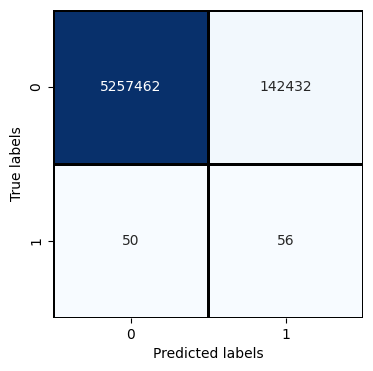

-------------------------
Reading in 328.csv
---
Shape of the data initially is: (5400000, 6)
        405       488       633       red     green  label
0  0.004555 -0.011959 -0.005413  0.001627  0.000000      0
1  0.001779 -0.007623 -0.001290  0.000000  0.022597      0
2 -0.001735 -0.004725 -0.001565  0.000000  0.039534      0
3 -0.006129 -0.001373 -0.006099  0.000000  0.037457      0
4 -0.010059  0.005405 -0.010909  0.000000  0.025908      0
---
Shape of the data with features and predictions is: (300000, 12)
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.589547  -0.093850  -0.605471   0.245867  -0.767097  -0.923704   
1  -0.139906  -0.956325  -0.982833  -0.924753  -0.992364  -0.978317   
2   0.713192  -0.964521  -0.824726  -0.729437  -0.974484  -0.856681   
3   0.780443  -0.959445  -0.864153  -0.733594  -0.979033  -0.888750   
4   0.791070  -0.873905  -0.411216  -0.444139  -0.871540  -0.300520   

   feature_7  feature_8  feature_9  feature_10  feature_

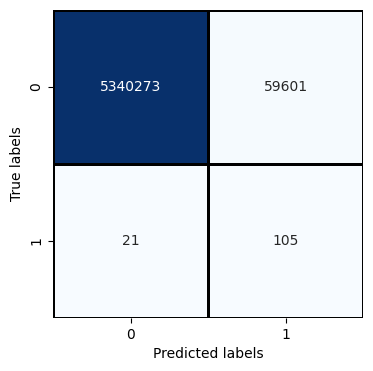

-------------------------
Reading in 431.csv
---
Shape of the data initially is: (5400000, 6)
        405       488       633  red     green  label
0 -0.000307  0.001788  0.000836  0.0  0.000000      0
1 -0.001388  0.003866  0.009669  0.0  0.002058      0
2 -0.002330  0.010469  0.022059  0.0  0.004214      0
3 -0.002675  0.021401  0.034700  0.0  0.000000      0
4 -0.002589  0.028666  0.040181  0.0  0.000000      0
---
Shape of the data with features and predictions is: (300000, 12)
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -0.128717  -0.888687  -0.948224  -0.896677  -0.970011  -0.259126   
1   0.742685  -0.931439  -0.533310  -0.744031  -0.939842   0.698320   
2  -0.064842  -0.801214  -0.835233  -0.686122  -0.910487  -0.779094   
3   0.867372  -0.422130  -0.243609   0.414338  -0.850373  -0.547201   
4   0.284239  -0.915610  -0.846051  -0.906733  -0.974470  -0.279495   

   feature_7  feature_8  feature_9  feature_10  feature_11  predictions  
0  -0.913481

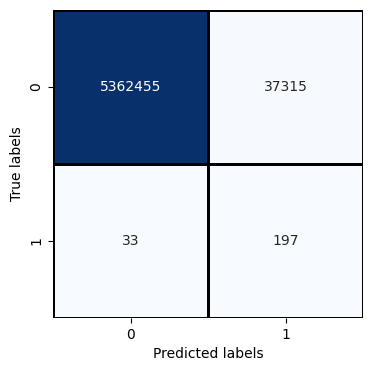

-------------------------


In [ ]:
# read files
for i in [217, 328, 431]:

  filename = f"{i}.csv"
  if os.path.exists(filename):

    # defining column names
    column_names = ['405', '488', '633', 'red', 'green', 'label']

    # define data types for each column - this makes reading faster since python does not have to infer the data type of each column (only slight improvement)
    dtypes = {'405': 'float64', '488': 'float64', '633': 'float64', 'red': 'float64', 'green': 'float64', 'label': 'int64'}

    print(f'Reading in {filename}')
    print('---')
    data = pd.read_csv(filename, header=None, names=column_names, dtype=dtypes)

    # shape of the data
    print(f'Shape of the data initially is: {data.shape}')
    print(data.head())
    print('---')

    # with K = 18, create modified label column
    data = modify_data(data)

    # drop the unnecessary columns
    data.drop(columns=['red', 'green', 'label'], inplace=True)

    # group size is the window for which correlation values will be calculated and given to the model
    group_size = 18

    # group the df into groups of size 'group_size' and apply the processing function
    data_with_features = data.groupby(data.index // group_size).apply(create_features)

    # getting the predictions using the saved model
    data_with_features['predictions'] = ML_n1_model.predict(data_with_features)
    print(f'Shape of the data with features and predictions is: {data_with_features.shape}')
    print(data_with_features.head())
    print('---')

    # create a new column with the predictions in the original dataset, repeated based on the group size
    data['label_pred'] = np.repeat(data_with_features['predictions'], group_size).values
    print(f'Shape of the data finally is: {data.shape}')
    print(data.head())
    print('---')

    # get model metrics
    get_model_metrics(data)

    # clear memory
    del data_with_features, data
    gc.collect()